# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [3]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [4]:
import re
from random import shuffle
from glob import glob

train_files = glob('./data/train/*.jpg')
test_files = glob('./data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

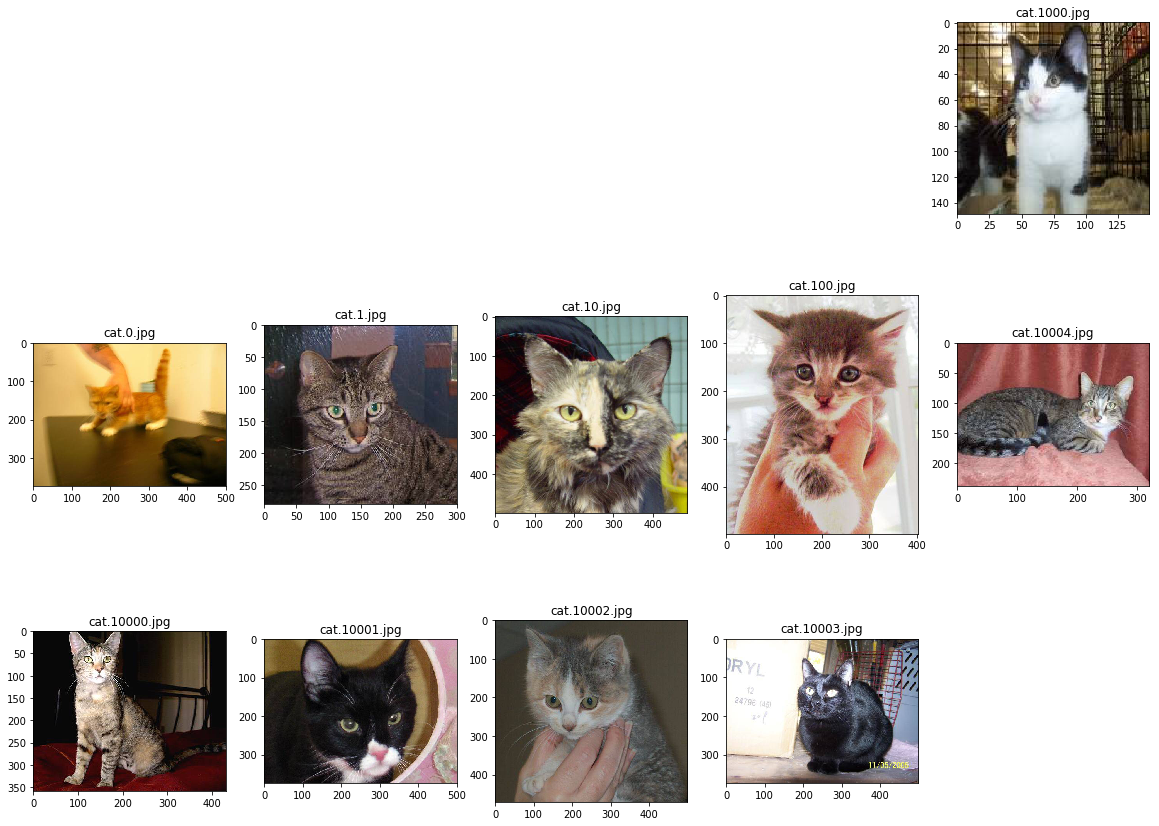

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('\\')[-1]);

## Загружаем предобученную модель

In [6]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [7]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

## Добавляем полносвязный слой

In [8]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3,  # один выход
                       activation='relu',  # функция активации  
                       kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [10]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [11]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

In [12]:
%%time
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=10,  # число вызовов генератора за эпоху
                    epochs=100,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 6s - loss: 0.9019 - acc: 0.6562 - val_loss: 0.5845 - val_acc: 0.6500
Epoch 2/100
10/10 [==============================] - 3s - loss: 0.4987 - acc: 0.8812 - val_loss: 0.4606 - val_acc: 0.9100
Epoch 3/100
10/10 [==============================] - 3s - loss: 0.3317 - acc: 0.9344 - val_loss: 0.3839 - val_acc: 0.9400
Epoch 4/100
10/10 [==============================] - 3s - loss: 0.2338 - acc: 0.9812 - val_loss: 0.1621 - val_acc: 0.9600
Epoch 5/100
10/10 [==============================] - 3s - loss: 0.3696 - acc: 0.9625 - val_loss: 0.0842 - val_acc: 0.9700
Epoch 6/100
10/10 [==============================] - 3s - loss: 0.2530 - acc: 0.9563 - val_loss: 0.2678 - val_acc: 0.9300
Epoch 7/100
10/10 [==============================] - 3s - loss: 0.1960 - acc: 0.9750 - val_loss: 0.2655 - val_acc: 0.9700
Epoch 8/100
10/10 [==============================] - 3s - loss: 0.1822 - acc: 0.9594 - val_loss: 0.1768 - val_acc: 0.9800
Epoch 9/100
10/10 [=====

10/10 [==============================] - 3s - loss: 0.1216 - acc: 0.9812 - val_loss: 0.1083 - val_acc: 0.9900
Epoch 68/100
10/10 [==============================] - 3s - loss: 0.0912 - acc: 0.9812 - val_loss: 0.1311 - val_acc: 0.9700
Epoch 69/100
10/10 [==============================] - 3s - loss: 0.0598 - acc: 0.9969 - val_loss: 0.1353 - val_acc: 0.9700
Epoch 70/100
10/10 [==============================] - 3s - loss: 0.1121 - acc: 0.9812 - val_loss: 0.1228 - val_acc: 0.9700
Epoch 71/100
10/10 [==============================] - 3s - loss: 0.1332 - acc: 0.9688 - val_loss: 0.1060 - val_acc: 0.9800
Epoch 72/100
10/10 [==============================] - 3s - loss: 0.0448 - acc: 0.9875 - val_loss: 0.1259 - val_acc: 0.9800
Epoch 73/100
10/10 [==============================] - 3s - loss: 0.1350 - acc: 0.9656 - val_loss: 0.1035 - val_acc: 0.9900
Epoch 74/100
10/10 [==============================] - 3s - loss: 0.1021 - acc: 0.9719 - val_loss: 0.0976 - val_acc: 0.9700
Epoch 75/100
10/10 [=========

## Предсказания на проверочной выборке

In [13]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

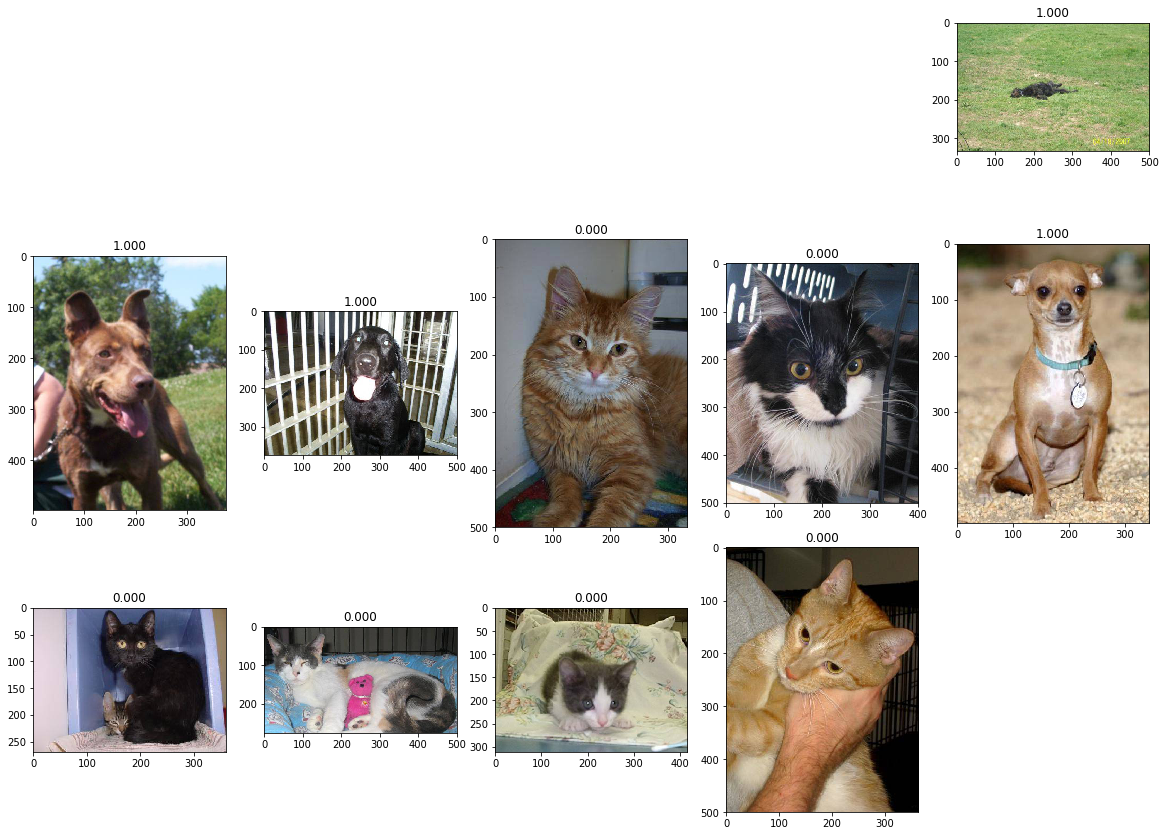

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [16]:
pred

array([[  1.00000000e+00],
       [  1.56922908e-07],
       [  1.85225963e-06],
       ..., 
       [  1.00000000e+00],
       [  1.63668072e-11],
       [  7.64820527e-07]], dtype=float32)

In [19]:
pred.shape

(12500, 1)

In [21]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\\d+)', path).group(0), np.clip(score,0.0125,0.9875) ))

In [ ]:
# LogLoss = 1.04979